## Car-Following trajectory analysis

- Goal: Extract the acceleration histogram during car-following periods.

- Sources of data:

1. [The I-24 Motion dataset](https://i24motion.org/), [paper](https://i24motion.org/)
    - Among all the different dates for which the data was made available, 4 hours of November-22, 2022 was used.
    - The original sampling rate of this dataset is 0.04 second per timestep. This is linearly interpolated to obtain and standard 0.1 second per timestep.

| Data Source                  | Duration | Length | Lanes | speed limit | Original Sampling rate | 
|------------------------------|------------------|----------------|-------|---------------| ---------------|
| The I-24 Motion dataset     |   4 hours    |   6.75km  |   usually 4    |    70 mph  |  0.04   |

----

Car following filter used to extract car-following periods:
- Vehicle types: 
    - For I-24: vehicle class 0: sedan, 1: midsize



In [1]:
import os
import ijson 
import bigjson
import scipy.io 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from pathlib import Path
import seaborn as sns
sns.set_style("whitegrid")
datapath = './Data/i_24/637c399add50d54aa5af0cf4__post2.json'

## First: I-24 Motion dataset
Notes: 
- Data covers both directions with multiple lanes
- 

<img width="900" alt="1" src="https://github.com/poudel-bibek/AI-Assignments/assets/96804013/2ef05f8f-c2c7-4350-91dc-fdd5c30fd705">

Total: 14

In [ ]:
with open(datapath, 'rb') as file:
    json_data = bigjson.load(file)
    
    datum = json_data[10]

    # What are the various keys in data
    keys = datum.keys()
    print(f"Total: {len(keys)}\n")
    for i in range(len(keys)):
        print(f"{i+1}: {keys[i-1]}")
    
    print("\n\n")
    for key, value in datum.iteritems():
        print(key, value)

file.close()

# Extra 9
# 'coarse_vehicle_class', 'fine_vehicle_class', 'x_score', 'y_score', 'compute_node_id', 'local_fragment_id', 'merged_ids', 'road_segment_ids', 'flags'


### Step 1: Resample + Save only the required data to CSV
- Linear interpolation seems difficult:
    - Computationally expensive (crashes the notebook)  
    - Time consuming compared to resampling
    - Cant get precise 0.1 intervals (shocking), np.arange can only generate 0.1, 0.
    - Resampling only has a small error at every other data point by 0.02 seconds (first data point is 0.0, then 0.12, then 0.20, then 0.32)

In [ ]:
# Approach 3: Process data in chunks
chunk_size = 10000000  # 10 million
columns=['id', 'timestamp', 'x_position', 'y_position', 'class_fine', 'class_coarse', 'direction']

def process_datum(datum):
    data_points = []
    id = datum["_id"]['$oid']
    timestamp = datum["timestamp"]
    x_position = datum["x_position"]
    y_position = datum["y_position"]
    class_fine = datum["fine_vehicle_class"]
    class_coarse = datum["coarse_vehicle_class"]
    direction = datum["direction"]
    
    length = len(timestamp)
    for j in range(length):
        data_point = [id, timestamp[j], x_position[j], y_position[j], class_fine, class_coarse, direction]
        data_points.append(data_point)
        
    return data_points

# Open the JSON file
with open(datapath, 'r') as file:
    # Parse the JSON objects one by one
    parser = ijson.items(file, 'item')
    chunks = []
    
    # start by adding a header 
    temp_df = pd.DataFrame(columns=columns)
    temp_df.to_csv('temporary_chunks.csv', mode='a', header=True, index=False)
    
    try:
        i = 1
        while True:
            datum = next(parser)
            chunks.extend(process_datum(datum))
            
            if len(chunks) >= chunk_size:
                temp_df = pd.DataFrame(chunks, columns=columns)
                temp_df.to_csv('temporary_chunks.csv', mode='a', header=False, index=False)  # Saving chunks to a temporary file
                chunks = []
                print(f"Chunk {i}, {i*10}M data processed.")
                i += 1
                
    except StopIteration:
        print("All data has been processed.")
        
    finally:
        if chunks:  # Saving remaining data
            temp_df = pd.DataFrame(chunks, columns=columns)
            temp_df.to_csv('temporary_chunks.csv', mode='a', header=False, index=False)
        file.close()

In [ ]:
df = pd.read_csv('temporary_chunks.csv')

# Converting 'timestamp' to numeric values, setting errors='coerce' to handle non-numeric values
df['float_timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')

# Dropping the original 'timestamp' column
df = df.drop(['timestamp'], axis=1)

pd.set_option('display.float_format', '{:.4f}'.format)
df.head(20)

In [ ]:
# Summary of data, what values can variables take
print(f"Unique ids (Before): {len(df['id'].unique())}\n")
print(f"Fine: {df['class_fine'].value_counts()}\n")
print(f"Coarse classes (Before):\n{df['class_coarse'].value_counts()}")

# Fine class can be dropped (no use)
df = df.drop(['class_fine'], axis=1)

# Filter data by class only keep class 0 and 1
df = df[df['class_coarse'].isin([0, 1])]
print(f"Unique ids (After): {len(df['id'].unique())}\n")
print(f"\nCoarse After (After):\n{df['class_coarse'].value_counts()}")

# Corse class can also be dropped (made use of it)
df = df.drop(['class_coarse'], axis=1)

print(f"Shape of new data: {df.shape}")

In [ ]:
# Resample
new_df = pd.DataFrame(columns=['id', 't', 'x', 'y', 'direction'])

# Create a list to temporarily store the rows
rows_to_append = []

# Number of rows to process before printing a progress update
progress_interval = 10000000 # 10 million

# Iterating over DataFrame rows as tuples
for i, row in enumerate(df.itertuples(index=False)):
    
    if i % progress_interval == 0:
        print(f"Processed {i} rows so far...")
    
    # Check if rows_to_append is not empty and if the id is the same as the previous one
    if rows_to_append and row.id == rows_to_append[-1]['id']:
        if str(row.float_timestamp)[11] != str(rows_to_append[-1]['t'])[11]:
            rows_to_append.append({'id': row.id, 't': row.float_timestamp, 'x': row.x_position, 'y': row.y_position, 'direction': row.direction})
    else:
        rows_to_append.append({'id': row.id, 't': row.float_timestamp, 'x': row.x_position, 'y': row.y_position, 'direction': row.direction})

# Convert the list of dictionaries into a DataFrame
new_df = pd.DataFrame(rows_to_append)

print(f"Processing complete. {len(new_df)} rows added.")
new_df.head(20)


In [ ]:
# Save to csv file
new_df.to_csv('./Data/i_24/resampled_i24.csv', header=True, index=False)
# From the initial 247 million data points, reduced to 74 million.

### Step 2: Remove extra lanes and assign lane ids

In [ ]:
loaded_df = pd.read_csv('./Data/i_24/resampled_i24.csv')
loaded_df.head(20)

subset_df = loaded_df #.iloc[:1000000].copy()

In [ ]:
directions = subset_df['direction'].unique()
direction_mapping = {-1: 'Westbound', 1: 'Eastbound'}

plt.figure(figsize=(15, 8))  # Adjusted size for two subplots

lane_definitions = {}

for index, direction in enumerate(directions):
    plt.subplot(1, 2, index + 1)  # 1 row, 2 columns, subplot index

    direction_df = subset_df[subset_df['direction'] == direction].copy()
    num_clusters = 5

    kmeans = KMeans(n_clusters=num_clusters)
    direction_df['cluster'] = kmeans.fit_predict(direction_df[['y']])

    for cluster_id in direction_df['cluster'].unique():
        cluster_data = direction_df[direction_df['cluster'] == cluster_id]
        plt.scatter(cluster_data['x'], cluster_data['y'], label=f'Cluster {cluster_id}', alpha=0.5)

    sorted_centroids = sorted(kmeans.cluster_centers_[:, 0])
    lane_boundaries = []
    for i in range(len(sorted_centroids) - 1):
        boundary = (sorted_centroids[i] + sorted_centroids[i + 1]) / 2
        lane_boundaries.append(boundary)

    lane_definitions[direction_mapping[direction]] = lane_boundaries

    # Calculate the y-tick locations
    y_min, y_max = plt.ylim()
    y_interval = (y_max - y_min) / 24
    y_ticks = [y_min + i * y_interval for i in range(25)]
    plt.yticks(y_ticks)

    plt.xlabel('X (Longitudinal)')
    plt.ylabel('Y (Lateral)')
    plt.title(f'{direction_mapping[direction]}')
    plt.legend()

plt.tight_layout()
plt.suptitle('Clustering of Y-positions to identify lanes within directions', y=1.05) 
plt.show()


# Preliminary Lane ranges
# print("Premliminary Lane Ranges\n")
# for direction, boundaries in lane_definitions.items():
#     print(f"{direction} Lane Boundaries:")
#     for i, boundary in enumerate(boundaries):
#         if i == 0:
#             size = boundary - y_min
#             print(f"Lane 1: < {boundary} (Size: {size:.2f})")
#         else:
#             size = boundary - boundaries[i-1]
#             print(f"Lane {i+1}: {boundaries[i-1]} to {boundary} (Size: {size:.2f})")
    
#     size = y_max - boundaries[-1]
#     print(f"Lane {len(boundaries)+1}: > {boundaries[-1]} (Size: {size:.2f})")
#     print("\n")

<img width="700" alt="poles_lanes" src="https://github.com/poudel-bibek/AI-Assignments/assets/96804013/71b81420-6dbe-46f8-a2aa-d599241913c1">
<p>
From the real-world: Its mostly always 4 lane

Remove the entire vehicle if:
- For any vehicle Westbound (-1), if a trajectory has a value lower than -60 or higher than -8
- For any vehicle Eastbound (1), if a trajectory has a value lower than  2 or higher than 58

__further revise the lane boundaries as follows__
__The typical size of a lane in interstate highways is 12 ft, use the Figure below from the paper as well__

<img width="700" alt="paper_lanes" src="https://github.com/poudel-bibek/4-Degrees-Of-Freedom/assets/96804013/51bba06b-acef-4ffb-9198-3044e469f425
">

This figure in the paper is misleading/ confusing (It does say that its just of a couple sections). I am not following the figure for lane demarcations, following what is shown below.

| Lane | Westbound      | Eastbound        |
|------|----------------|------------------|
| 1    |   3 to 15      | -9 to -21        |
| 2    |   16 to 28     | -22 to -34       |
| 3    |   29 to 41     | -35 to -47       |
| 4    |   42 to 54    | -48 to -60       |

In [ ]:
# Define the thresholds
upper_threshold_east = -8 #54
lower_threshold_east = -60 # 2

upper_threshold_west = 54 #-8
lower_threshold_west = 2 #-64

# Remove vehicles that don't meet the criteria
# This will also remove the vehicles that at any point exit the highway
to_remove_east = subset_df[
    (subset_df['direction'] == 1) & # Eastbound 
    ((subset_df['y'] > upper_threshold_east) | (subset_df['y'] < lower_threshold_east)) # Data points to remove
]['id'].unique()

to_remove_west = subset_df[
    (subset_df['direction'] == -1) & # Westbound
    ((subset_df['y'] > upper_threshold_west) | (subset_df['y'] < lower_threshold_west)) # Data points to remove
]['id'].unique()

subset_df = subset_df[~subset_df['id'].isin(to_remove_east)]
subset_df = subset_df[~subset_df['id'].isin(to_remove_west)]

print(f"Shape of the remaining data: {subset_df.shape}")

In [ ]:
# redo the clustering plot for validation
directions = subset_df['direction'].unique()
direction_mapping = {-1: 'Westbound', 1: 'Eastbound'}

plt.figure(figsize=(15, 10))  # Adjusted size for two subplots

lane_definitions = {}

for index, direction in enumerate(directions):
    plt.subplot(1, 2, index + 1)  # 1 row, 2 columns, subplot index

    direction_df = subset_df[subset_df['direction'] == direction].copy()
    num_clusters = 5

    kmeans = KMeans(n_clusters=num_clusters)
    direction_df['cluster'] = kmeans.fit_predict(direction_df[['y']])

    for cluster_id in direction_df['cluster'].unique():
        cluster_data = direction_df[direction_df['cluster'] == cluster_id]
        plt.scatter(cluster_data['x'], cluster_data['y'], label=f'Cluster {cluster_id}', alpha=0.5)

    sorted_centroids = sorted(kmeans.cluster_centers_[:, 0])
    lane_boundaries = []
    for i in range(len(sorted_centroids) - 1):
        boundary = (sorted_centroids[i] + sorted_centroids[i + 1]) / 2
        lane_boundaries.append(boundary)

    lane_definitions[direction_mapping[direction]] = lane_boundaries

    # Calculate the y-tick locations
    y_min, y_max = plt.ylim()
    y_interval = (y_max - y_min) / 24
    y_ticks = [y_min + i * y_interval for i in range(25)]
    plt.yticks(y_ticks)

    plt.xlabel('X (Longitudinal)')
    plt.ylabel('Y (Lateral)')
    plt.title(f'{direction_mapping[direction]}')
    plt.legend()

plt.tight_layout()
plt.suptitle('Clustering of Y-positions to identify lanes within directions', y=1.05) 
plt.show()

In [ ]:
def assign_lane_vectorized(y_values, directions):
    # Define boundaries. These dont match the table (but to make the output match, because of how left, right work below they have to be set this way)
    eastbound_boundaries = np.array([-8, -21, -34, -47, -60])  # 1
    westbound_boundaries = np.array([2, 16, 29, 42, 55])       # -1

    # Prepare output array
    lanes = np.zeros_like(y_values, dtype=np.int)

    # For Eastbound: directions == 1
    # Invert the eastbound_boundaries to ascending order for searchsorted
    ascending_boundaries_east = eastbound_boundaries[::-1]
    eastbound_indices = np.searchsorted(ascending_boundaries_east, y_values, side='right')
    eastbound_lanes = len(ascending_boundaries_east) - eastbound_indices

    # For Westbound: directions == -1
    westbound_lanes = np.searchsorted(westbound_boundaries, y_values, side='left')

    # Assign lanes based on direction
    lanes[directions == 1] = eastbound_lanes[directions == 1]
    lanes[directions == -1] = westbound_lanes[directions == -1]

    # There should be no values outside the range
    # Handle values outside the boundaries for eastbound
    #lanes[(directions == 1) & (y_values > -8)] = 0
    #lanes[(directions == 1) & (y_values < -60)] = 5

    # Handle values outside the boundaries for westbound
    #lanes[(directions == -1) & (y_values < 2)] = 0
    #lanes[(directions == -1) & (y_values > 54)] = 5

    return lanes

# Apply the function and assign the lane IDs
subset_df['lane_id'] = assign_lane_vectorized(subset_df['y'].values, subset_df['direction'].values)

# Save this to a CSV file
subset_df.to_csv('./Data/i_24/processed_i24.csv', header=True, index=False)

# Display the first few rows
pd.set_option('display.float_format', '{:.4f}'.format)
print(subset_df.head())

### Step 3: Find leader, get leader params: id, headway
- A leader only exists if the ego and leader are in the same lane i.e., in the same timesteps, leader is going in same direction + lane as ego vehicle with difference in x
- The difference in x_position is the headway

In [2]:
# load data
processed_df = pd.read_csv('./Data/i_24/processed_i24.csv')

# How are lanes distributed?
# print(processed_df['lane_id'].value_counts())

# # Check for Nan or missing values
# print(processed_df.isnull().sum())

In [3]:
# find leader and add the id and headway, if no leader then -1 
# Around the same time stamp, the leader travels the same lane as ego vehicle with a difference in x position
# Only cosidered a leader if the difference in x position is positive 150m
# Eastbound (1) or Westbound (-1), x-values are always positive. 
# In Westbound, the leader will have a x-value higher than follower
# In Eastbound, the leader will have a x-value lower than follower

# What if there are multiple leaders?
# For now, we will only consider the closest leader. But how to get the closest leader?
# We can sort the leader dataframe by x-value and take the first row.

def find_leader(group, threshold):

    # Initialize the leader DataFrame with the same index as group
    leader_df = pd.DataFrame(index=group.index)
    leader_df['leader'] = -1
    leader_df['headway'] = -1

    # Iterate over the unique IDs directly
    for unique_id in group['id'].unique():
        current_vehicle = group[group['id'] == unique_id]
        x_value = current_vehicle['x'].iloc[0]
        direction = current_vehicle['direction'].iloc[0]

        # Define masks for potential leaders based on direction
        mask_eastbound = (group['x'] < x_value) & (group['direction'] == 1)
        mask_westbound = (group['x'] > x_value) & (group['direction'] == -1)
        mask_potential_leaders = mask_eastbound if direction == 1 else mask_westbound

        # Find potential leaders
        potential_leaders = group[mask_potential_leaders].copy()
        if not potential_leaders.empty:
            potential_leaders['x_diff'] = (potential_leaders['x'] - x_value).abs()
            leader = potential_leaders[potential_leaders['x_diff'] < threshold].nsmallest(1, 'x_diff')

            if not leader.empty:
                leader_index = group[group['id'] == unique_id].index
                leader_df.loc[leader_index, 'leader'] = leader['id'].values[0]
                leader_df.loc[leader_index, 'headway'] = leader['x_diff'].values[0]

    # Concatenate the group data with the leader data
    result = pd.concat([group.reset_index(drop=True), leader_df.reset_index(drop=True)], axis=1)
    return result

# Open CSV file for appending results
csv_file_path = Path('./Data/i_24/second_processed_i24.csv')
csv_exists = csv_file_path.exists()

groups = processed_df.groupby(['t', 'lane_id', 'direction'])

# Pre-calculate the number of groups to avoid recomputing it every iteration
print("Total groups:", len(groups))

# Process the dataframe in chunks
group_count = 0

# Because we have not converted to meters yet
threshold =  492.126 # This is 150meters in ft # Max headway to be considered a leader
results = []  # Initialize a list to store intermediate dataframes

for name, group in groups:
    group_count += 1 
    results.append(find_leader(group, threshold))

    # Check if we've processed 20000 groups, or if we are at the last one. 
    if group_count % 20000 == 0:

        print(f"Processing chunk at group #{group_count}: t={group['t'].iloc[0]}")

        # Concatenate all the dataframes in the list
        result_df = pd.concat(results, ignore_index=True)
        
        # Write the result_df to CSV file in append mode
        result_df.to_csv(csv_file_path, mode='a', header=not csv_exists, index=False)
        
        csv_exists = True

        # Clear the list for the next chunk
        results = []

# If there are any remaining groups that haven't been written after the loop
if results:
    result_df = pd.concat(results, ignore_index=True)
    with open(csv_file_path, 'a') as f:
        result_df.to_csv(f, header=not csv_file_path.exists(), index=False)

Total groups: 5842992
Processing chunk at group #20000: t=1669118511.5200007
Processing chunk at group #40000: t=1669118571.7000005
Processing chunk at group #60000: t=1669118626.4200006
Processing chunk at group #80000: t=1669118682.9
Processing chunk at group #100000: t=1669118736.8200002
Processing chunk at group #120000: t=1669118791.1000006
Processing chunk at group #140000: t=1669118842.5000005
Processing chunk at group #160000: t=1669118895.0200007
Processing chunk at group #180000: t=1669118947.7200005
Processing chunk at group #200000: t=1669118999.7200005
Processing chunk at group #220000: t=1669119051.0000005
Processing chunk at group #240000: t=1669119100.42
Processing chunk at group #260000: t=1669119150.8000007
Processing chunk at group #280000: t=1669119201.7
Processing chunk at group #300000: t=1669119250.8000007
Processing chunk at group #320000: t=1669119300.2
Processing chunk at group #340000: t=1669119349.5
Processing chunk at group #360000: t=1669119398.3200002
Pro

### Step 4: Go through all vehicles and calculate thier instantaneous Velocity and Acceleration.
First perform a number of smaller steps
- Y values are not needed drop them
- Convert x values to meters 
- Filter: Only consider a vehicle if it has a leader.

Then:
- Only if the difference in two consecitive timesteps is either 0.8 or 0.12 ~ both cases approximated as 0.1
- Needs initial two values to be removed (because of differentiation twice) for every data point (to avoid having Nan)


In [4]:
# load last_processed_i24
new_df = pd.read_csv('./Data/i_24/second_processed_i24.csv')

# drop y_values
new_df = new_df.drop(['y'], axis=1)

# Convert distances in ft to meters
new_df['x'] = new_df['x'] * 0.3048
new_df['headway'] = new_df['headway'] * 0.3048

print(f"Shape of the new data: {new_df.shape}")
print(new_df.dtypes)

pd.set_option('display.float_format', '{:.4f}'.format)
new_df.head(20)
# 74 Million

Shape of the new data: (74251152, 7)
direction      int64
id            object
t            float64
x            float64
lane_id        int64
leader        object
headway      float64
dtype: object


,direction,id,t,x,lane_id,leader,headway
0,-1,638b78907b4691ecaa928e7a,1669118401.9000,97067.3758,0,-1,-0.3048
1,-1,638b78907b4691ecaa928e7a,1669118402.0200,97067.3022,0,-1,-0.3048
2,-1,638b78907b4691ecaa928e7a,1669118402.1000,97067.2639,0,-1,-0.3048
3,-1,638b78907b4691ecaa928e7a,1669118402.2200,97067.2209,0,-1,-0.3048
4,-1,638b78907b4691ecaa928e7a,1669118402.3000,97067.2005,0,-1,-0.3048
5,-1,638b78907b4691ecaa928e7a,1669118402.4200,97067.1801,0,-1,-0.3048
6,-1,638b78907b4691ecaa928e7a,1669118402.5000,97067.1721,0,-1,-0.3048
7,-1,638b78907b4691ecaa928e7a,1669118402.6200,97067.1659,0,-1,-0.3048
8,-1,638b78907b4691ecaa928e7a,1669118402.7000,97067.1645,0,-1,-0.3048
9,-1,638b78907b4691ecaa928e7a,1669118402.8200,97067.1643,0,-1,-0.3048


In [5]:
# only consider data points with a leader
with_leader_df = new_df[new_df['leader'] != '-1'] # for some reason -1 has to be a string.

print(f"Shape of the new data: {with_leader_df.shape}")
print(with_leader_df.dtypes)

pd.set_option('display.float_format', '{:.4f}'.format)
with_leader_df.head(20)
# 30 Million

Shape of the new data: (30754866, 7)
direction      int64
id            object
t            float64
x            float64
lane_id        int64
leader        object
headway      float64
dtype: object


,direction,id,t,x,lane_id,leader,headway
259,-1,638b787da5b418cbd76f804b,1669118413.6000,100347.0519,2,638b787ea5b418cbd76f804d,12.8095
267,-1,638b787da5b418cbd76f804b,1669118413.7200,100343.4382,2,638b787ea5b418cbd76f804d,12.9798
271,-1,638b787da5b418cbd76f804b,1669118413.8000,100341.0288,2,638b787ea5b418cbd76f804d,13.0879
280,-1,638b787da5b418cbd76f804b,1669118413.9200,100337.4141,2,638b787ea5b418cbd76f804d,13.2419
284,-1,638b787da5b418cbd76f804b,1669118414.0000,100335.0038,2,638b787ea5b418cbd76f804d,13.3392
294,-1,638b787da5b418cbd76f804b,1669118414.1200,100331.3873,2,638b787ea5b418cbd76f804d,13.4772
298,-1,638b787da5b418cbd76f804b,1669118414.2000,100328.9755,2,638b787ea5b418cbd76f804d,13.5639
308,-1,638b787da5b418cbd76f804b,1669118414.3200,100325.3564,2,638b787ea5b418cbd76f804d,13.6861
312,-1,638b787da5b418cbd76f804b,1669118414.4000,100322.9425,2,638b787ea5b418cbd76f804d,13.7624
322,-1,638b787da5b418cbd76f804b,1669118414.5200,100319.3198,2,638b787ea5b418cbd76f804d,13.8692


In [6]:
# calculate velocity and acceleration of the current vehicle
# For every vehicle id, if the difference between two consecutive timesteps is either 0.12 or 0.08, then we can calculate the velocity and acceleration
# remove the two initial points?

def calculate_velocity_acceleration(df):
    # sort the data, need only t because grouped by id already
    df = df.sort_values(['t'])  

    # Calculate the differences
    df['delta_x'] = df.groupby('id')['x'].diff()
    df['delta_t'] = df.groupby('id')['t'].diff() # Divide by the actual time-step 0.08 or 0.12 # To avoid approximation error

    # Avoid division by zero by replacing zero in delta_t with NaN
    df['delta_t'].replace(0, np.nan, inplace=True)

    # Calculate velocity and acceleration
    df['velocity'] = df['delta_x'] / df['delta_t']
    df['acceleration'] = df.groupby('id')['velocity'].diff() / df['delta_t']

    # Drop the intermediate delta columns if they are not needed
    df.drop(['delta_x', 'delta_t'], axis=1, inplace=True)
    return df

# Path to CSV file
csv_file_path = './Data/i_24/velocity_acceleration_i24.csv'
csv_exists = Path(csv_file_path).exists()

# Group the dataframe by the required fields
groups = with_leader_df.groupby(['id'])  
print("Found", len(groups), "groups.")

results = []  # Initialize a list to store intermediate dataframes
for group_idx, (group_name, group) in enumerate(groups, start=1):
    results.append(calculate_velocity_acceleration(group))
    
    # Check if we've processed a chunk's worth of groups or if we are at the last one.
    if group_idx % 20000 == 0:
        print(f"Processing chunk at group #{group_idx}")
        
        # Concatenate all the dataframes in the list
        result_df = pd.concat(results, ignore_index=True)
        
        # Write the result_df to CSV file in append mode
        result_df.to_csv(csv_file_path, mode='a', header=not csv_exists, index=False)
        csv_exists = True
        
        # Clear the list for the next chunk
        results = []

# If there are any remaining groups that haven't been written after the loop
if results:
    result_df = pd.concat(results, ignore_index=True)
    result_df.to_csv(csv_file_path, header=not csv_exists, index=False)

# 360,000

Found 364495 groups.
Processing chunk at group #20000
Processing chunk at group #40000
Processing chunk at group #60000
Processing chunk at group #80000
Processing chunk at group #100000
Processing chunk at group #120000
Processing chunk at group #140000
Processing chunk at group #160000
Processing chunk at group #180000
Processing chunk at group #200000
Processing chunk at group #220000
Processing chunk at group #240000
Processing chunk at group #260000
Processing chunk at group #280000
Processing chunk at group #300000
Processing chunk at group #320000
Processing chunk at group #340000
Processing chunk at group #360000


### Step 5: Apply remaining of the car-following filter (in the given order)

- Follower speed is greater than 10% of the speed limit (in m/s) i.e., 3.12 m/s (to avoid approach to standing traffic).
- Space headway is less than 62m. Apply 2 second rule to the speed limit (avoid free-flow).
- Both leader and follower remain in the same lane for > 10s

__Note: longitudional data is already in meters, meters per second, meters per second squared__

In [146]:
# Load data 
velocity_accn_df = pd.read_csv('./Data/i_24/velocity_acceleration_i24.csv')
# add header 
velocity_accn_df.columns = ['direction', 'id', 't', 'x', 'lane_id', 'leader_id', 'headway', 'velocity', 'acceleration']

# size of data
print(f"Shape of the new data: {velocity_accn_df.shape}")

# remove all rows with NaN
velocity_accn_df = velocity_accn_df.dropna()

pd.set_option('display.float_format', '{:.4f}'.format)
velocity_accn_df.head(20)
# 275,000

Shape of the new data: (274506, 9)


,direction,id,t,x,lane_id,leader_id,headway,velocity,acceleration
1,-1,638c27c03fc03ef13312f609,1669131830.2000,99893.4142,1,638c1aeda5b418cbd77134da,5.9864,-33.6837,-1.0357
2,-1,638c27c03fc03ef13312f609,1669131830.3200,99889.3621,1,638c1aeda5b418cbd77134da,5.7676,-33.7675,-0.6988
3,-1,638c27c03fc03ef13312f609,1669131831.8000,99838.2250,2,638c1aeda5b418cbd77134da,4.8334,-34.5521,-0.5301
4,-1,638c27c03fc03ef13312f609,1669131831.9200,99833.9712,2,638c1b11a5b418cbd7713537,34.0432,-35.4486,-7.4712
5,-1,638c27c03fc03ef13312f609,1669131832.0000,99831.1263,2,638c1b11a5b418cbd7713537,34.1134,-35.5613,-1.4089
6,-1,638c27c03fc03ef13312f609,1669131832.1200,99826.8459,2,638c1b11a5b418cbd7713537,34.2251,-35.6698,-0.9041
7,-1,638c27c03fc03ef13312f609,1669131832.2000,99823.9840,2,638c1b11a5b418cbd7713537,34.3037,-35.7736,-1.2970
8,-1,638c27c03fc03ef13312f609,1669131832.3200,99819.6795,2,638c1b11a5b418cbd7713537,34.4278,-35.8712,-0.8136
9,-1,638c27c03fc03ef13312f609,1669131832.4000,99816.8024,2,638c1b11a5b418cbd7713537,34.5143,-35.9626,-1.1426
10,-1,638c27c03fc03ef13312f609,1669131832.5200,99812.4769,2,638c1b11a5b418cbd7713537,34.6497,-36.0460,-0.6945


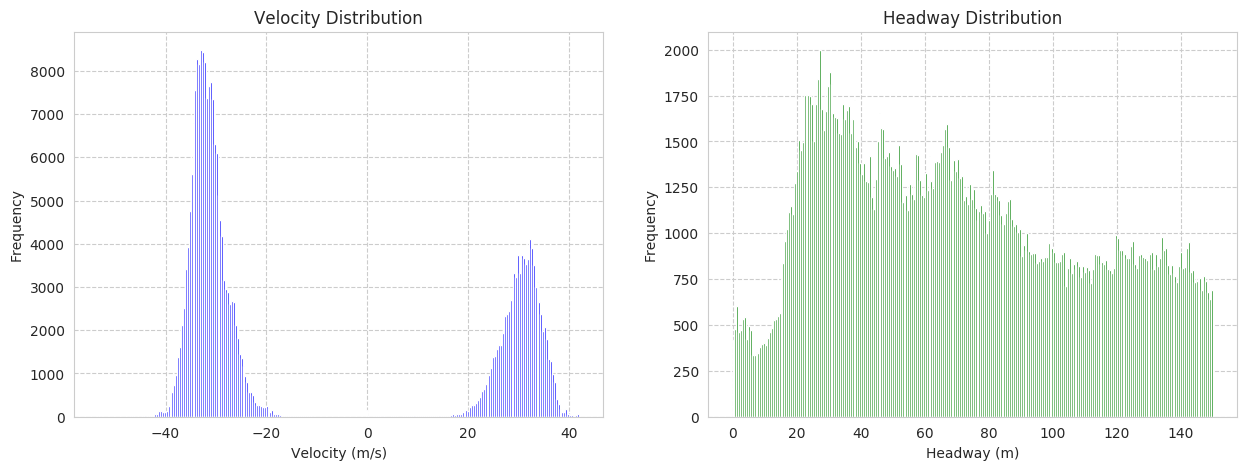

In [147]:
# Plot histogram of velocity and headways 
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(velocity_accn_df['velocity'], bins=250, color='blue')
ax[0].set_xlabel('Velocity (m/s)')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Velocity Distribution')

ax[1].hist(velocity_accn_df['headway'], bins=250, color='green')
ax[1].set_xlabel('Headway (m)')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Headway Distribution')
plt.show()

Shape of the new data: (229678, 9)


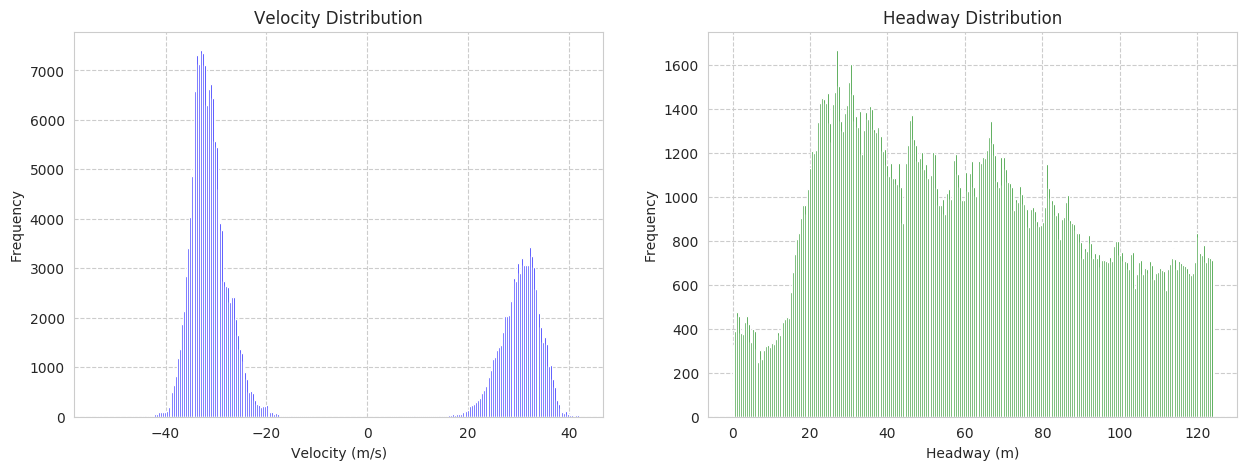

In [148]:
# drop rows with velocity less than 3.125 m/s and higher than -3.125 m/s i.e. only consider outside this range
filtered_accn_df = velocity_accn_df[~velocity_accn_df['velocity'].between(-3.125, 3.125)]

# drop rows with headway greater than 62m i.e. only consider below threshold
filtered_accn_df = filtered_accn_df[filtered_accn_df['headway'] <= 124] #62 is 2s rule, 124 is 4s rule # 124

# size of data
print(f"Shape of the new data: {filtered_accn_df.shape}")

# plot again 
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(filtered_accn_df['velocity'], bins=250, color='blue')
ax[0].set_xlabel('Velocity (m/s)')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Velocity Distribution')

ax[1].hist(filtered_accn_df['headway'], bins=250, color='green')
ax[1].set_xlabel('Headway (m)')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Headway Distribution')
plt.show()

In [149]:
# only consider a vehicle if the total consecutive time (without missing data) is greater than 10 seconds
# group by leader ids (imporaant, the same leader has to stick around for the threshold time)
groups = filtered_accn_df.groupby(['leader_id'])
print("Found", len(groups), "groups.")

# for each group sort by timesteps and check for consecutive timesteps
# if consecutive timesteps is greater than 5 seconds then keep the group else remove the group
# if the group is kept then append to a new dataframe
new_df = pd.DataFrame(columns=['id', 't', 'x', 'direction', 'lane_id', 'leader_id', 'headway', 'velocity', 'acceleration'])

for group_idx, (group_name, group) in enumerate(groups, start=1):
    
    group = group.sort_values(['t'])  
    group['delta_t'] = group.groupby('id')['t'].diff()
    
    # the first one is going to have a nan
    group['delta_t'].replace(0, np.nan, inplace=True)
    group = group.dropna()

    #print(group['delta_t'])
    if group['delta_t'].sum() >= 5:
        new_df = new_df.append(group, sort=False)

# drop delta_t
new_df = new_df.drop(['delta_t'], axis=1)

# save to a file
print(f"Shape of the data: {new_df.shape}")
new_df.to_csv('./Data/i_24/final_i24.csv', header=True, index=False)

pd.set_option('display.float_format', '{:.4f}'.format)
new_df.head(20)

# Our setup allows ego vehicle to maintain a small headway at speed greater > 10% of the speed limit
# 172294

Found 5060 groups.
Shape of the data: (172294, 9)


,id,t,x,direction,lane_id,leader_id,headway,velocity,acceleration
3734,638c27e6e38fd878abf65fcb,1669131694.8200,96910.1529,-1,3,638c18587b4691ecaa9465bb,62.8426,-32.9121,-0.4760
3735,638c27e6e38fd878abf65fcb,1669131694.9000,96907.5154,-1,3,638c18587b4691ecaa9465bb,63.0227,-32.9695,-0.7180
3736,638c27e6e38fd878abf65fcb,1669131695.0200,96903.5521,-1,3,638c18587b4691ecaa9465bb,63.2973,-33.0269,-0.4781
3755,638c27e6e38fd878abf65fcb,1669131705.4200,96555.5973,-1,3,638c18587b4691ecaa9465bb,99.2360,-32.8833,-0.0917
3756,638c27e6e38fd878abf65fcb,1669131705.5000,96552.9552,-1,3,638c18587b4691ecaa9465bb,99.7663,-33.0256,-1.7786
3757,638c27e6e38fd878abf65fcb,1669131705.6200,96548.9891,-1,3,638c18587b4691ecaa9465bb,100.5497,-33.0514,-0.2150
3758,638c27e6e38fd878abf65fcb,1669131705.7000,96546.3429,-1,3,638c18587b4691ecaa9465bb,101.0632,-33.0767,-0.3157
3759,638c27e6e38fd878abf65fcb,1669131705.8200,96542.3708,-1,3,638c18587b4691ecaa9465bb,101.8189,-33.1013,-0.2053
3760,638c27e6e38fd878abf65fcb,1669131705.9000,96539.7208,-1,3,638c18587b4691ecaa9465bb,102.3121,-33.1251,-0.2979
3761,638c27e6e38fd878abf65fcb,1669131706.0200,96535.7430,-1,3,638c18587b4691ecaa9465bb,103.0351,-33.1477,-0.1881


### Step 6: More analytics for (intensity, frequency, duration) + Perform Visualization

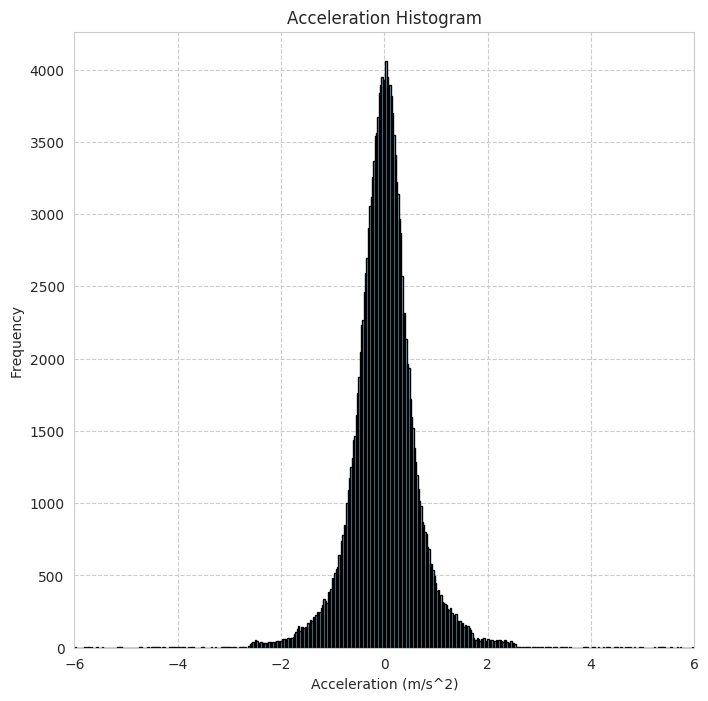

In [150]:
# Load the processed data (which is small enough to be uploaded to GitHub as well)
data_real = pd.read_csv('./Data/i_24/final_i24.csv') 

# Intensity
# plot histogram of acceleration
fig, ax = plt.subplots(figsize=(8, 8), dpi=100)  
ax.hist(data_real['acceleration'], bins=5000, color='skyblue', edgecolor='black')
ax.set_xlim(-6, 6)
ax.set_xlabel('Acceleration (m/s^2)')
ax.set_ylabel('Frequency')
ax.set_title('Acceleration Histogram')
ax.grid(True)
plt.show()

# Length/ Duration of accelerations
# plot histogram of acceleration durations in a specific bucket




# Frequency


### Step 7: Final Plot for paper

In [151]:
directory = './Data/Typical_IDM_data/'
files = os.listdir(directory)
file_directories = [] 
for i in files:
    file_directories.append(directory + i)
file_directories

['./Data/Typical_IDM_data/idm_20230814-0934541692020094.644299-0_emission.csv',
 './Data/Typical_IDM_data/idm_20230814-0935251692020125.6047704-0_emission.csv',
 './Data/Typical_IDM_data/idm_20230814-0935541692020154.0609777-0_emission.csv',
 './Data/Typical_IDM_data/idm_20230814-0936211692020181.9302511-0_emission.csv',
 './Data/Typical_IDM_data/idm_20231203-1621221701638482.4120765-0_emission.csv',
 './Data/Typical_IDM_data/idm_20231203-1621541701638514.0580835-0_emission.csv',
 './Data/Typical_IDM_data/idm_20231203-1622561701638576.5006447-0_emission.csv',
 './Data/Typical_IDM_data/idm_20231203-1623291701638609.0742772-0_emission.csv',
 './Data/Typical_IDM_data/idm_20231203-1631181701639078.107496-0_emission.csv',
 './Data/Typical_IDM_data/idm_20231203-1631471701639107.8036137-0_emission.csv']

176220
176220


/home/kurukshetra/anaconda3/envs/flow/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/kurukshetra/anaconda3/envs/flow/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1.00000e+00, 2.00000e+00, 2.60000e+01, 3.55000e+02, 2.25600e+03,
        5.21700e+03, 2.89060e+04, 1.20351e+05, 1.46790e+04, 4.04100e+03]),
 array([-2.54529678, -2.19918988, -1.85308298, -1.50697607, -1.16086917,
        -0.81476227, -0.46865537, -0.12254846,  0.22355844,  0.56966534,
         0.91577224]),
 <a list of 10 Patch objects>)

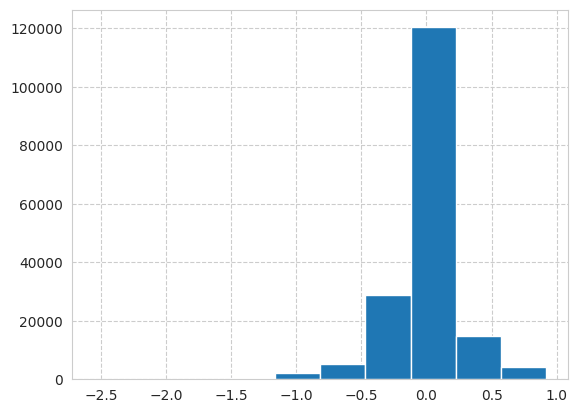

In [152]:
# Accelerations should not be in free flow, neither should they be in SGT
# get all idm vehicles acceleration data before shock time
def get_realized_accel(data, start_time, end_time):
    # get all unique vehicle ids
    vehicle_ids = data['id'].unique()

    # get all idm vehicles, if the id has human 
    idm_vehicles = [id for id in vehicle_ids if 'idm' in id]

    all_vehicle_data = []
    # get all idm vehicles acceleration data before shock time
    for veh in idm_vehicles:
        veh_data = data[data['id'] == veh]
        # Include both start and end time
        veh_data = veh_data[(veh_data['time'] >= start_time) & (veh_data['time'] <= end_time)]
        #veh_data = veh_data[veh_data['time'] > start_time]
        # just get realized_accel 
        veh_data = veh_data['target_accel_with_noise_no_failsafe']
        all_vehicle_data.append(veh_data)
    return all_vehicle_data



# For a certain initial period the system is mostly stable and near zero accelerations are present
start_time = 80
end_time = 160 #220

all_data_idm = []
for j in file_directories:
    data = get_realized_accel(pd.read_csv(j), start_time, end_time)
    for k in data:
        all_data_idm.extend(k)
print(len(all_data_idm)) # The total volume of data has to be the same (to just look at thier distributions)\

# randomly sample (with equal probability) the same volume 
all_data_idm_sampled = all_data_idm#random.sample(all_data_idm, len(all_data))

#print(len(all_data))
print(len(all_data_idm_sampled))

plt.hist(all_data_idm_sampled)

<Figure size 640x480 with 0 Axes>

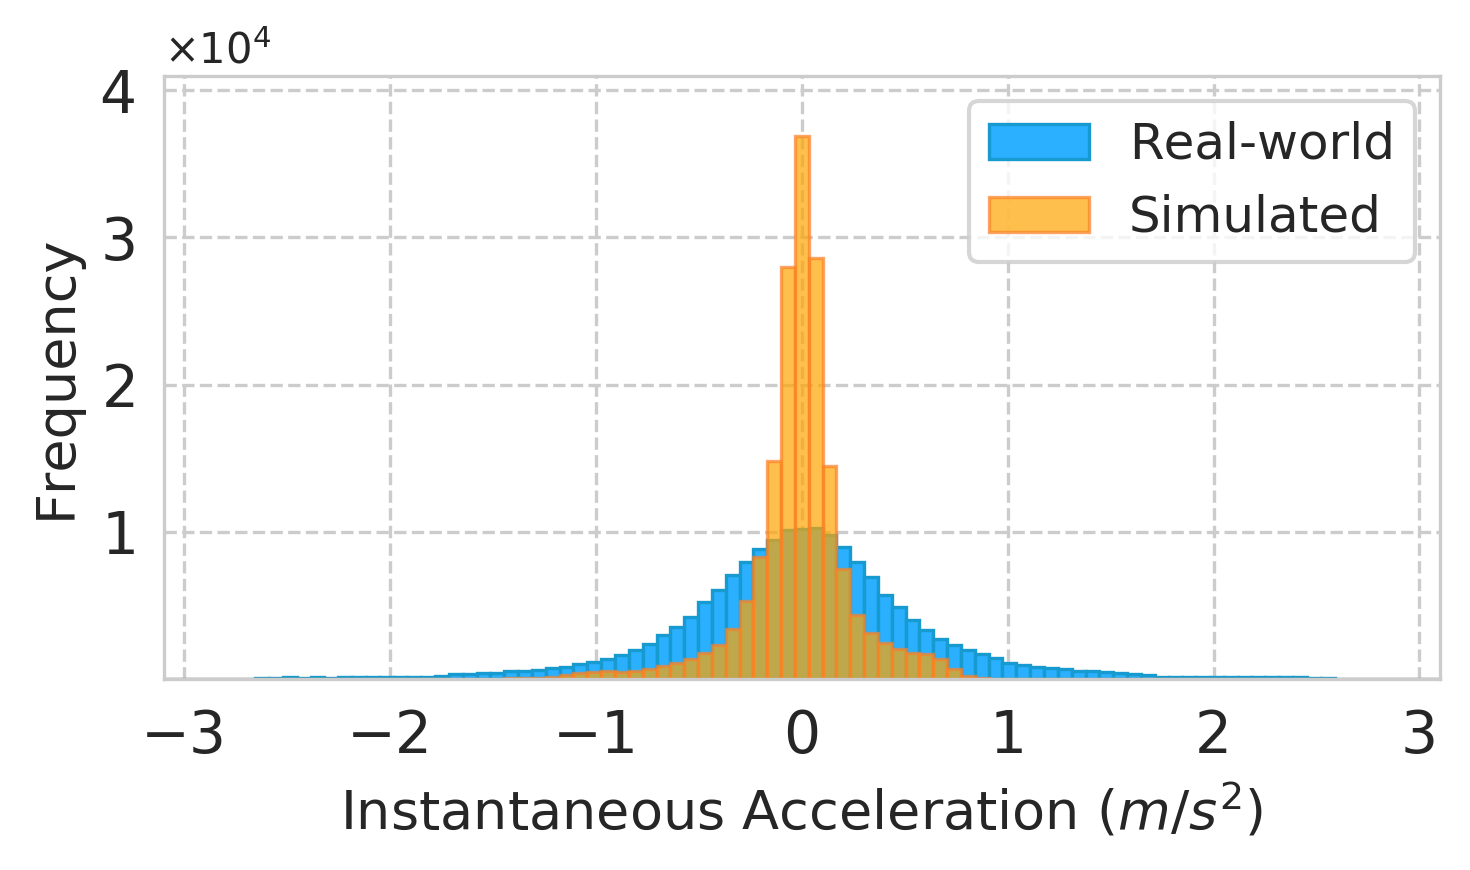

In [153]:
import seaborn as sns
import matplotlib.ticker as mticker

plt.rcParams["text.color"] = 'black'
sns.set_style("whitegrid", {"grid.linestyle": "--"})
fontsize = 14

plt.subplots_adjust( right=0.5)
fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
fig.subplots_adjust(right=2.85)  # Add padding of 15% of the plot width to the right

plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)

ax.set_xlim(-3.1, 3.1)
ax.set_ylim(0, 41e3)
ax.set_yticks( [10000, 20000, 30000, 40000] )#np.linspace(0.0, 6.5e3, 5))
ax.set_xticks( [ -3, -2, -1, 0, 1, 2, 3] )

n_bins = 1000 # Number of equal width bins in the range
n_bins_2 = np.linspace(-4, 4, 120)

# ax.hist(data_real['acceleration'], bins=n_bins, histtype='bar', facecolor = '#2ab0ff', alpha =1.0, edgecolor='#169acf', linewidth=1.0, label = "Real-world")# ,histtype="stepfilled", zorder=1)
# ax.hist(all_data_idm_sampled, bins= n_bins, histtype='bar', facecolor = '#FFA500', alpha =0.6, edgecolor='#FA8128', linewidth=1.0, label = "Simulated") #, histtype="stepfilled", zorder=2)

ax.hist(data_real['acceleration'], bins=n_bins_2, facecolor = '#2ab0ff', alpha =1.0, edgecolor='#169acf', linewidth=0.8, label = "Real-world", histtype="bar", range=(-3, 3))
ax.hist(all_data_idm_sampled, bins= n_bins_2, facecolor = '#FFA500', alpha =0.7, edgecolor='#FA8128', linewidth=0.8, label = "Simulated", histtype="bar", range=(-3, 3))


formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
formatter.set_scientific(True)
ax.yaxis.set_major_formatter(formatter)

fs = 13
ax.set_xlabel("Instantaneous Acceleration $(m/s^{2})$", fontsize = fs)
ax.set_ylabel("Frequency", fontsize = fs)


ax.legend(fontsize = fs-1)                             
fig.tight_layout()
plt.savefig('./real_accel.pdf', format ='pdf')
plt.savefig('./real_accel_png.png')
plt.show()

In [155]:
# Percentage inside and outside [-1, 1] in all_data_idm_sampled and data_real['acceleration']
# Percentage of accelerations inside [-1, 1] in all_data_idm_sampled
inside = 0
outside = 0
for i in all_data_idm_sampled:
    if i >= -0.5 and i <= 0.5:
        inside += 1
    else:
        outside += 1
print(f"Percentage of accelerations inside [-1, 1] in all_data_idm_sampled: {inside/len(all_data_idm_sampled)}")

# Percentage of accelerations inside [-1, 1] in data_real['acceleration']
inside = 0
outside = 0
for i in data_real['acceleration']:
    if i >= -0.5 and i <= 0.5:
        inside += 1
    else:
        outside += 1
print(f"Percentage of accelerations inside [-1, 1] in data_real['acceleration']: {inside/len(data_real['acceleration'])}")


Percentage of accelerations inside [-1, 1] in all_data_idm_sampled: 0.9243445692883895
Percentage of accelerations inside [-1, 1] in data_real['acceleration']: 0.6885556084367418
